In [1]:
# All libraries
import jetset
print('tested on jetset',jetset.__version__)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from jetset.data_loader import Data
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.jet_model import Jet
from jetset.minimizer import fit_SED,ModelMinimizer
from jetset.model_manager import  FitModel
from jetset.sed_shaper import  SEDShape
from jetset.obs_constrain import ObsConstrain
from jetset.minimizer import fit_SED
from jetset.template_2Dmodel import EBLAbsorptionTemplate
from jetset.mcmc import McmcSampler

tested on jetset 1.2.2


---> excluding  data_set/s ['-1']
filter -1 37
current datasets
dataset 0.0
---> data sets left after filtering None
---> data len after filtering=37

***  binning data  ***
---> N bins= 113
---> bin_widht= 0.15

---> setting  UL
---> Settin  UL for val [0, 0, 2.94e-13, 7.22e-14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.29e-12, 0, 0, 0, 1.38e-13, 5.38e-13, 7.93e-13]


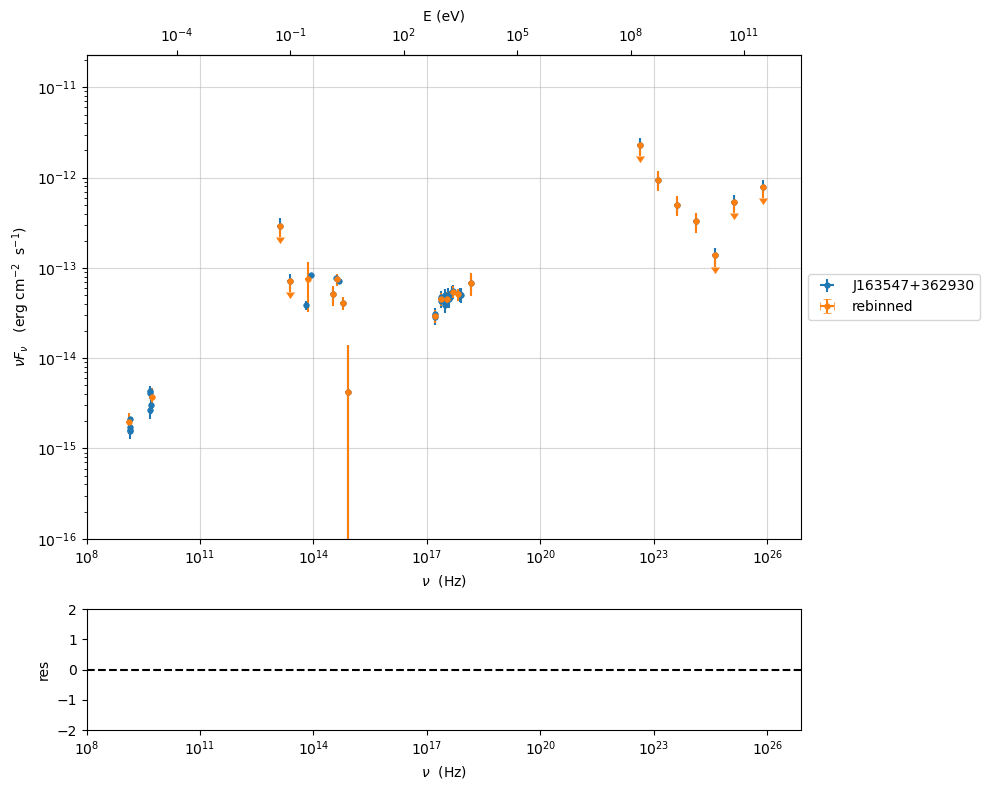

In [2]:
d=np.genfromtxt('sed2.txt')
data=Data(n_rows=d.shape[0])
data.set_field('x',d[:,0])
data.set_field('y',d[:,1])
data.set_field('dy',value=d[:,2])
#data.table[22]['UL']=True
#data.table[23]['UL']=True
data.set_meta_data('z',3.647763)
data.set_meta_data('UL_CL', 0.95)
data.set_meta_data('restframe','obs')
data.set_meta_data('data_scale','lin-lin')
data.set_meta_data('obj_name','J163547+362930')

sed_data=ObsData(data_table=data)
myPlot=sed_data.plot_sed()
sed_data.filter_data_set('-1',exclude=True)
sed_data.group_data(bin_width=.15)
sed_data.add_systematics(0.15,[10.**6,10.**29])
sed_data.set_UL([0,0,2.94E-13,7.22e-14,0,0,0,0,
                 0,0,0,0,0,0,0,2.29e-12,0,0,0,
                 1.38e-13,5.38e-13,7.93e-13])
myPlot.add_data_plot(sed_data,label='rebinned')
myPlot.setlim(y_min=1E-16,x_min=1E8)

#sed_data.save('J163547_data.pkl')


*** evaluating spectral indices for data ***
!Warning, no covariance matrix produced
!Warning, no covariance matrix produced
!Warning, no covariance matrix produced



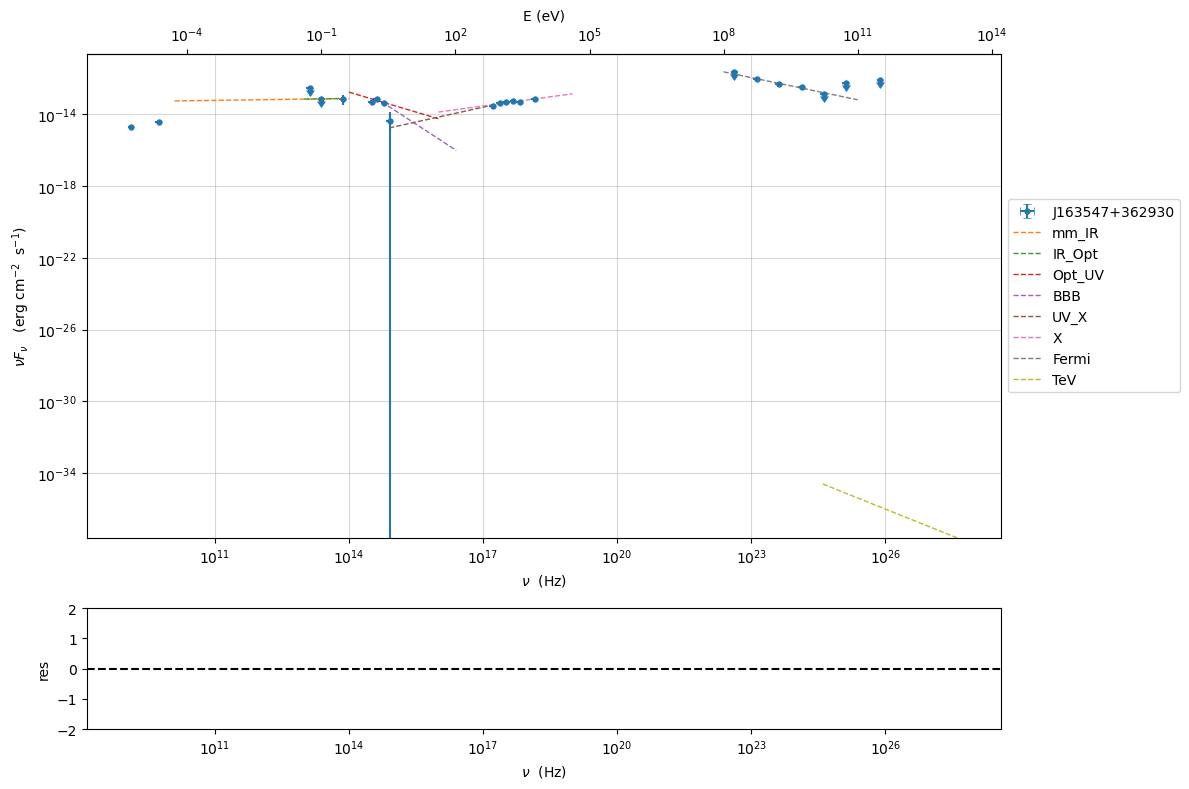

In [3]:
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [9, 16]
--> class:  LSP

!Warning, no covariance matrix produced
--> class:  LSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogParabolaEp,b,-8.834406e-02,-8.834406e-02,4.140533e-02,--,-8.694485e-02,-1.000000e+01,0.000000e+00,False
LogParabolaEp,Ep,1.313274e+01,1.313274e+01,8.246327e-01,--,1.346871e+01,0.000000e+00,3.000000e+01,False
LogParabolaEp,Sp,-1.334615e+01,-1.334615e+01,1.826663e-01,--,-1.313804e+01,-3.000000e+01,0.000000e+00,False
BBB,nuFnu_p_BBB,-1.357608e+01,-1.357608e+01,4.619709e-01,--,-1.313804e+01,-1.513804e+01,-1.113804e+01,False
BBB,nu_scale,5.029132e-03,5.029132e-03,5.427548e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.313274e+01 (err=+8.246327e-01)  nuFnu_p=-1.334615e+01 (err=+1.826663e-01) curv.=-8.834406e-02 (err=+4.140533e-02)


*** Log-Polynomial fitting of the IC component ***
---> fit range: [16, 26]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.357163e-01,-1.357163e-01,2.247093e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.432165e-02,-1.432165e-02,4.322339e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.211356e+01,2.211356e+01,1.622933e-01,--,2.120750e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.188857e+01,-1.188857e+01,1.207393e-01,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.211356e+01 (err=+1.622933e-01)  nuFnu_p=-1.188857e+01 (err=+1.207393e-01) curv.=-1.357163e-01 (err=+2.247093e-02)



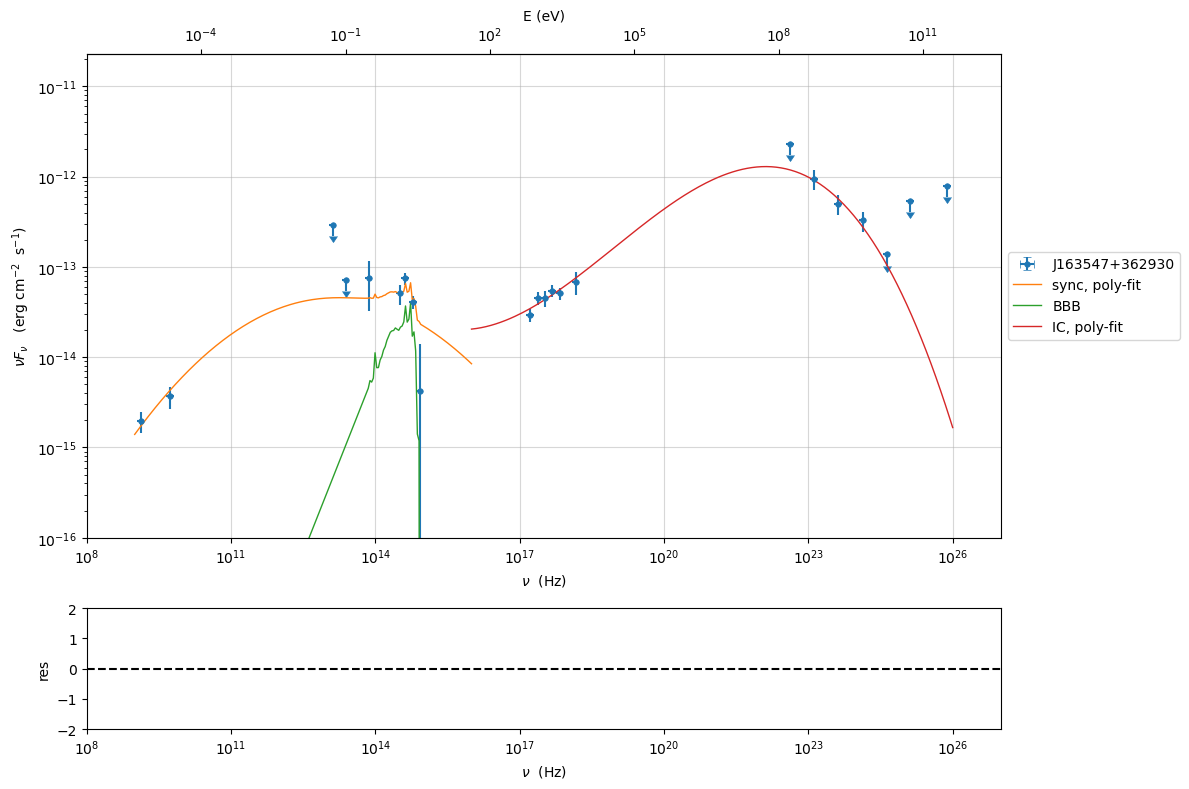

In [6]:
mm,best_fit=my_shape.sync_fit(check_BBB_template=True,
                              check_host_gal_template=False,
                              use_log_par=True,
                              Ep_start=None,
                              minimizer='lsb',
                              silent=True,
                              fit_range=[9,16])
my_shape.IC_fit(fit_range=[16,26],minimizer='minuit', silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-16)


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,7.450084e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.500000e+18,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,6.162219e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,theta,jet-viewing-angle,deg,3.000000e+00,0.000000e+00,--,False,False
jet_leptonic,BulkFactor,jet-bulk-factor,lorentz-factor*,1.850000e+01,1.000000e+00,1.000000e+05,False,False
jet_leptonic,z_cosm,redshift,,3.647763e+00,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,3.267129e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.987235e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,4.413552e+02,0.000000e+00,--,False,False




19.097330879509727


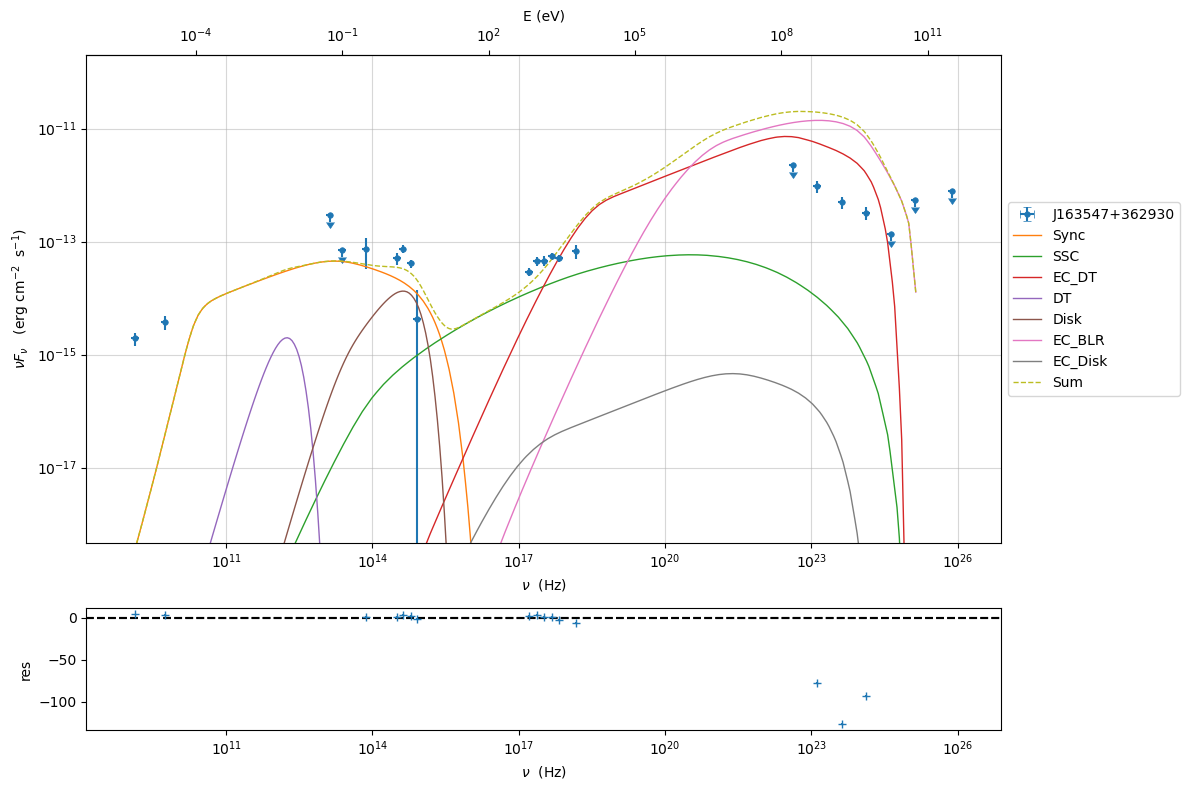

In [18]:
sed_obspar=ObsConstrain(theta=3,
                        bulk_factor=18.5,
                        B_range=[0.02,0.08],
                        distr_e='bkn',
                        t_var_sec=7*86400,
                        nu_cut_IR=1E9,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_EC_model(electron_distribution_log_values=False,
                                             EC_componets_list=['EC_DT','EC_BLR','EC_Disk'],
                                             R_H=1.5E18,
                                             disk_type='MultiBB',
                                             silent=True)
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data)
p.add_residual_plot(prefit_jet,sed_data)
p.save('prefit.png')
print(prefit_jet.get_beaming())
prefit_jet.save_model('PrePre.pkl')

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,3.267129e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.987235e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,4.413552e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,3.806596e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.320657e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,R_DT,DT,cm,5.000000e+18,0.000000e+00,--,False,False
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,False
jet_leptonic,R_inner_Sw,Disk,Sw. radii*,3.000000e+00,0.000000e+00,--,False,False


==> par R is now depending on ['R_H', 'theta_open'] according to expr:R =
np.tan((theta_open*np.pi/180))*R_H
==> par R_BLR_in is now depending on ['L_Disk'] according to expr:R_BLR_in =
3E17*(L_Disk/1E46)**0.5
==> par R_BLR_out is now depending on ['R_BLR_in'] according to expr:R_BLR_out =
R_BLR_in*1.1
==> par R_DT is now depending on ['L_Disk'] according to expr:R_DT =
2E19*(L_Disk/1E46)**0.5


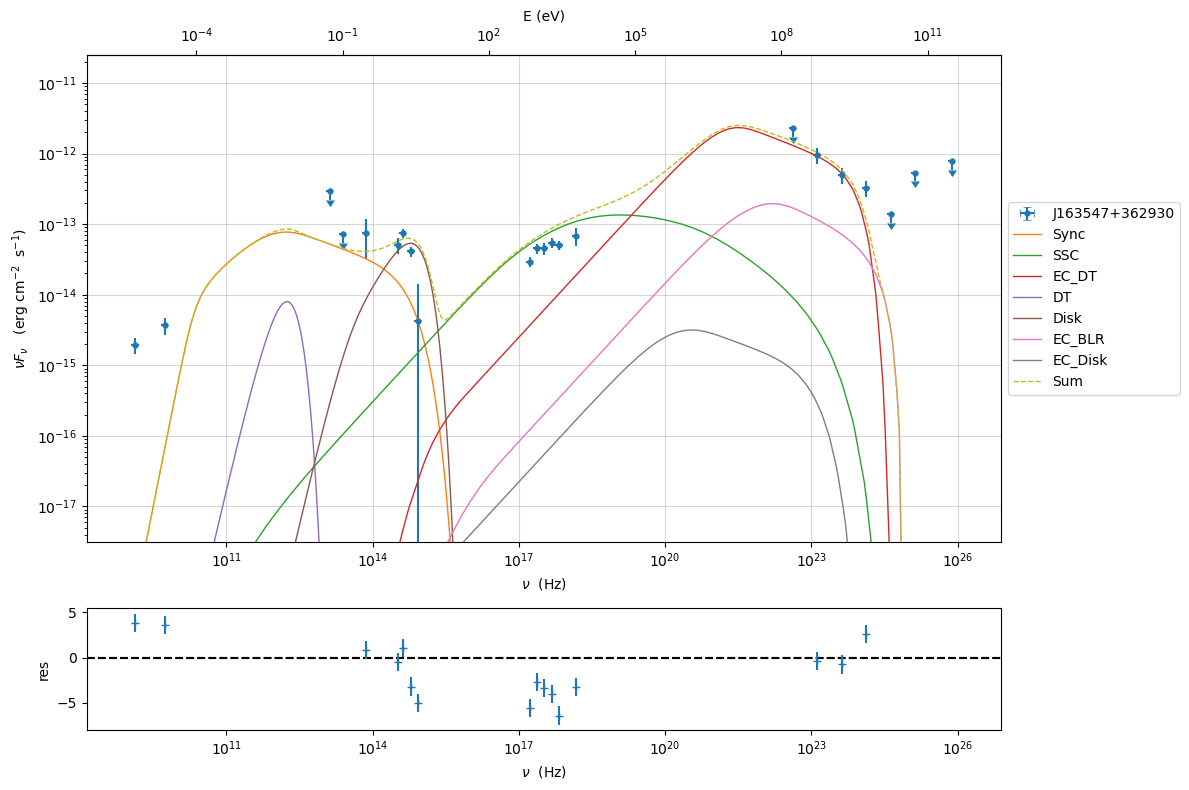

In [32]:
prefit_jet=Jet.load_model('PrePre.pkl')
prefit_jet.add_user_par(name='theta_open',val=3,units='deg')
prefit_jet.make_dependent_par(par='R', depends_on=['R_H','theta_open'],
                              par_expr='np.tan((theta_open*np.pi/180))*R_H')

prefit_jet.make_dependent_par(par='R_BLR_in', depends_on=['L_Disk'], par_expr='3E17*(L_Disk/1E46)**0.5')
prefit_jet.make_dependent_par(par='R_BLR_out', depends_on=['R_BLR_in'], par_expr='R_BLR_in*1.1')
prefit_jet.make_dependent_par(par='R_DT', depends_on=['L_Disk'], par_expr='2E19*(L_Disk/1E46)**0.5')

prefit_jet.set_par('L_Disk',val=1.381e46)
prefit_jet.set_par('gmin',val=1.00)
prefit_jet.set_par('gmax',val=2.00e4)
prefit_jet.set_par('gamma_break',val=1.00e3)
prefit_jet.set_par('N',val=1.50e3)
prefit_jet.set_par('p',val=1.5)
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data, frame='obs')
p.add_residual_plot(prefit_jet,sed_data)
#p.save('prefit2.png')

filtering data in fit range = [1.000000e+08,1.000000e+30]
data length 22

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=3.60971e+01

fit run: 1
- old chisq=3.60971e+01


0it [00:00, ?it/s]

- best chisq=3.59863e+01

fit run: 2
- old chisq=3.59863e+01


0it [00:00, ?it/s]

- best chisq=3.59863e+01

-------------------------------------------------------------------------
Fit report

Model: Sum


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.000000e+00,1.000000e+00,1.000000e+09,False,True
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.000000e+04,1.000000e+00,1.000000e+15,False,True
jet_leptonic,N,emitters_density,1 / cm3,7.022429e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,8.239845e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,1.374243e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.300190e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,8.366683e+02,0.000000e+00,--,False,False
jet_leptonic,"*R_DT(D,L_Disk)",DT,cm,2.364663e+19,0.000000e+00,--,False,True
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,True
jet_leptonic,R_inner_Sw,Disk,Sw. radii*,1.169233e+01,0.000000e+00,--,False,False



converged=True
calls=412
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.99                      │              Nfcn = 412              │
│ EDM = 0.0239 (Goal: 0.0002)      │           time = 126.4 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0  │    700    │    50     │            │            │   400   │  2000   │       │
│ 1 │ par_1  │  0.82e3   │  0.12e3   │            │            │   800   │  2000   │       │
│ 2 │ par_2  │   1.374   │   0.017   │            │            │  1.35   │   1.6   │       │
│ 3 │ par_3  │    3.3    │    0.5    │            │            │   3.3   │   3.8   │       │
│ 4 │ par_4  │   0.8e3   │   0.6e3   │            │            │   100   │   900   │       │
│ 5 │ par_5  │   11.69   │   0.12    │            │            │    3    │   15    │       │
│ 6 │ par_6  │  0.06e3   │  0.14e3   │            │            │   50    │  1000   │       │
│ 7 │ par_7  │  0.999e9  │  0.011e9  │            │            │  9e+08  │  2e+09  │       │
│ 8 │ par_8  │13.9791e45 │ 0.0009e45 │            │            │  1e+46  │  5e+46  │       │
│ 9 │ par_9  │1.50328e18 │0.00013e18 │            │            │  5e+17  │  3e+18  │       │
│ 10│ par_10 │   0.067   │   0.009   │            │            │  0.01   │   0.1   │       │
│ 11│ par_11 │    21     │     4     │            │            │   10    │   25    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9    par_10    par_11 │
├────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  par_0 │  2.41e+03  1.14e+03     0.111      12.4     -55.4    -0.453  1.66e+03  -3.1e+07  8.69e+42  1.11e+15    0.0885        84 │
│  par_1 │  1.14e+03  1.24e+04    -0.523      63.6      -323     -2.15  8.13e+03 -1.47e+08  4.67e+43  5.96e+15     0.679       408 │
│  par_2 │     0.111    -0.523  0.000291  -0.00511    0.0233  0.000184    -0.676  1.26e+04 -3.62e+39 -4.62e+11 -4.12e-05   -0.0341 │
│  par_3 │      12.4      63.6  -0.00511     0.418     -2.18   -0.0143      54.8 -9.77e+05  3.25e+41  4.15e+13   0.00489      2.79 │
│  par_4 │     -55.4      -323    0.0233     -2.18  8.59e+04    0.0938      -266  6.91e+06  7.08e+41  9.04e+13    0.0283      22.5 │
│  par_5 │    -0.453     -2.15  0.000184   -0.0143    0.0938    0.0157     -1.81     3e+04 -1.09e+40 -1.39e+12 -0.000159   -0.0936 │
│  par_6 │  1.66e+03  8.13e+03    -0.676      54.8      -266     -1.81  7.52e+03 -1.28e+08  4.05e+43  5.17e+15     0.631       344 │
│  par_7 │  -3.1e+07 -1.47e+08  1.26e+04 -9.77e+05  6.91e+06     3e+04 -1.28e+08  1.23e+14 -7.56e+47 -9.66e+19 -1.07e+04 -6.51e+06 │
│  par_8 │  8.69e+42  4.67e+43 -3.62e+39  3.25e+41  7.08e+41 -1.09e+40  4.05e+43 -7.56e+47  8.93e+83   7.1e+55  3.98e+39  1.81e+42 │
│  p

dof=10
chisq=35.986334, chisq/red=3.598633 null hypothesis sig=0.000085

stats without the UL
dof  UL=4
chisq=35.767374, chisq/red=8.941844 null hypothesis sig=0.000000


best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.000000e+00,--,--,--,1.000000e+00,5.000000e+00,2.000000e+01,True
jet_leptonic,gmax,2.000000e+04,--,--,--,2.000000e+04,1.000000e+00,1.000000e+15,True
jet_leptonic,N,7.022429e+02,7.022429e+02,4.906843e+01,--,1.308338e+03,4.000000e+02,2.000000e+03,False
jet_leptonic,gamma_break,8.239845e+02,8.239845e+02,1.222107e+02,--,8.730475e+02,8.000000e+02,2.000000e+03,False
jet_leptonic,p,1.374243e+00,1.374243e+00,1.689424e-02,--,1.525897e+00,1.350000e+00,1.600000e+00,False
jet_leptonic,p_1,3.300190e+00,3.300190e+00,4.909329e-01,--,3.300608e+00,3.300000e+00,3.800000e+00,False
jet_leptonic,T_DT,8.366683e+02,8.366683e+02,6.381776e+02,--,8.988243e+02,1.000000e+02,9.000000e+02,False
jet_leptonic,"*R_DT(D,L_Disk)",2.364663e+19,--,--,--,2.364680e+19,0.000000e+00,--,True
jet_leptonic,tau_DT,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,1.000000e+00,True
jet_leptonic,R_inner_Sw,1.169233e+01,1.169233e+01,1.253752e-01,--,1.197340e+01,3.000000e+00,1.500000e+01,False


-------------------------------------------------------------------------



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: Standard SSD  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
model description: 
--------------------------------------------------------------------------------
type: Jet
name: jet_leptonic  

electrons distribution:
 type: bkn  
 gamma energy grid size:  201
 gmin grid : 1.000000e+00
 gmax grid : 2.000000e+04
 normalization:  True
 log-values:  False
 ratio of cold protons to relativistic electrons: 1.000000e-01

accretion disk:
 disk Type: MultiBB
 L disk: 1.397908e+46 (erg/s)
 T di

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.000000e+00,1.000000e+00,1.000000e+09,False,True
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.000000e+04,1.000000e+00,1.000000e+15,False,True
jet_leptonic,N,emitters_density,1 / cm3,7.022429e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,8.239845e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,1.374243e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.300190e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,8.366683e+02,0.000000e+00,--,False,False
jet_leptonic,"*R_DT(D,L_Disk)",DT,cm,2.364663e+19,0.000000e+00,--,False,True
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,True
jet_leptonic,R_inner_Sw,Disk,Sw. radii*,1.169233e+01,0.000000e+00,--,False,False


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


name,type,units,val
BulkLorentzFactor,jet-bulk-factor,,2.094768e+01
U_e,Energy dens. blob rest. frame,erg / cm3,3.590155e-02
U_p_cold,Energy dens. blob rest. frame,erg / cm3,1.055665e-01
U_B,Energy dens. blob rest. frame,erg / cm3,1.796385e-04
U_Synch,Energy dens. blob rest. frame,erg / cm3,5.112487e-04
U_Synch_DRF,Energy dens. disk rest. frame,erg / cm3,6.700061e+01
U_Disk,Energy dens. blob rest. frame,erg / cm3,7.918459e-06
U_BLR,Energy dens. blob rest. frame,erg / cm3,3.290086e-04
U_DT,Energy dens. blob rest. frame,erg / cm3,3.528936e-03
U_CMB,Energy dens. blob rest. frame,erg / cm3,0.000000e+00


19.026619683082977


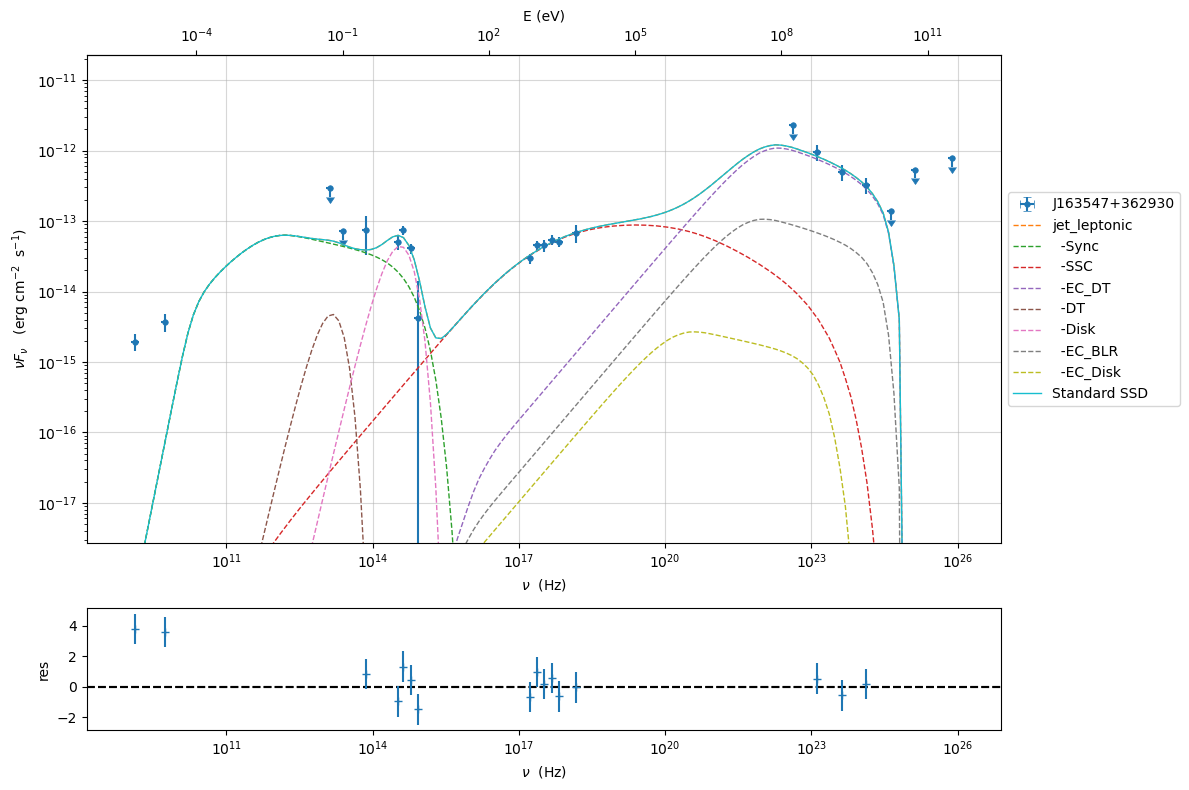

In [40]:
prefit_jet.set_par('BulkFactor',val=15.00)
prefit_jet.set_par('accr_eff',val=0.083)
prefit_jet.eval()

prefit_model=FitModel(jet=prefit_jet, name='Standard SSD',
                      template=None)

#ebl_franceschini=EBLAbsorptionTemplate.from_name('Franceschini_2008')
#prefit_model.add_component(ebl_franceschini)

#prefit_model.link_par(par_name='z_cosm',
#                      from_model='Franceschini_2008',
#                      to_model='jet_leptonic')

#prefit_model.composite_expr='(jet_leptonic)*Franceschini_2008'


prefit_model.jet_leptonic._blob.N_THREADS=8

prefit_model.free('jet_leptonic','R_H')
prefit_model.freeze('jet_leptonic','theta')
prefit_model.freeze('jet_leptonic','theta_open')
prefit_model.freeze('jet_leptonic','gmax')
prefit_model.freeze('jet_leptonic','gmin')
prefit_model.freeze('jet_leptonic','z_cosm')
prefit_model.freeze('jet_leptonic','accr_eff')
prefit_model.freeze('jet_leptonic','tau_DT')
prefit_model.freeze('jet_leptonic','tau_BLR')

prefit_model.jet_leptonic.parameters.R_H.fit_range=[5.0e+17,3.0e+18]
prefit_model.jet_leptonic.parameters.B.fit_range=[0.010,0.100]
prefit_model.jet_leptonic.parameters.BulkFactor.fit_range=[10.0,25.0]
prefit_model.jet_leptonic.parameters.N.fit_range=[4.00e+02,2.00e+03]
prefit_model.jet_leptonic.parameters.gamma_break.fit_range=[8.00e+02,2.00e+03]
prefit_model.jet_leptonic.parameters.p.fit_range=[1.35e+00,1.60e+00]
prefit_model.jet_leptonic.parameters.p_1.fit_range=[3.30e+00,3.80e+00]
prefit_model.jet_leptonic.parameters.R_inner_Sw.fit_range=[3.0e+00,1.5e+01]
prefit_model.jet_leptonic.parameters.R_ext_Sw.fit_range=[5.000e+01,1.00e+03]
prefit_model.jet_leptonic.parameters.M_BH.fit_range=[9.0000e+08,2.0000e+9]
prefit_model.jet_leptonic.parameters.T_DT.fit_range=[1.00000e+02,9.000e+02]
prefit_model.jet_leptonic.parameters.L_Disk.fit_range=[1.00e+46,5.00e+46]
model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(prefit_model,sed_data,10**8.,10**30.0,
                                           fitname='Sum',repeat=3, use_UL=True)
prefit_model.eval()
best_fit_minuit.save_report('Report_PrePre.pkl')
prefit_model.save_model('PrePre_model.pkl')
model_minimizer_minuit.save_model('model_minimizer_PrePre.pkl')
prefit_model.show_model()
prefit_model.jet_leptonic.energetic_report()
p2=prefit_model.plot_model(sed_data=sed_data)
p2.save('PrePre_model.png')
print(prefit_model.jet_leptonic.get_beaming())

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 1794.28 seconds


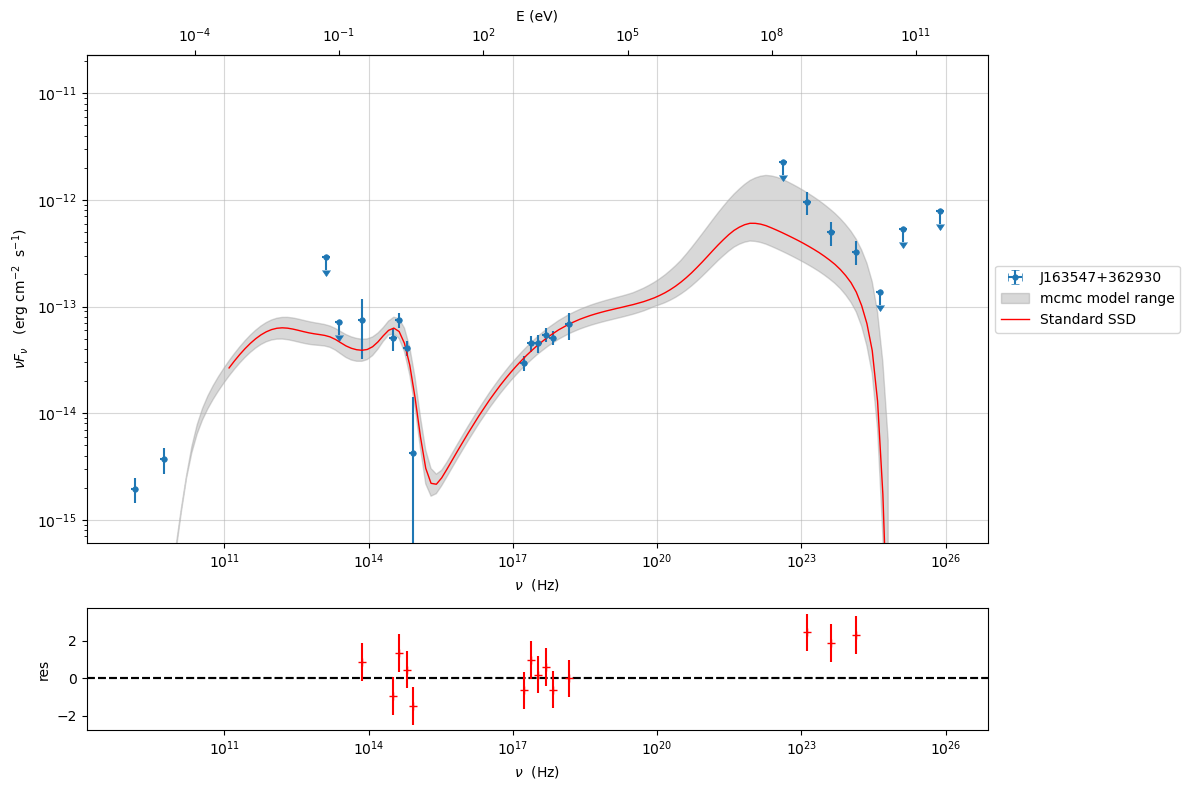

In [41]:
model_minimizer_minuit = ModelMinimizer.load_model('model_minimizer_PrePre.pkl')

mcmc=McmcSampler(model_minimizer_minuit)
mcmc.model.jet_leptonic._blob.N_THREADS=8
mcmc.model.jet_leptonic.set_external_field_transf('disk')
labels=['B','R_H','L_Disk','BulkFactor']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,
                 bound=5.0,bound_rel=True,threads=None,
                 walker_start_bound=0.005,use_labels_dict=use_labels_dict,
                 progress='notebook')
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11,2E28],size=100)

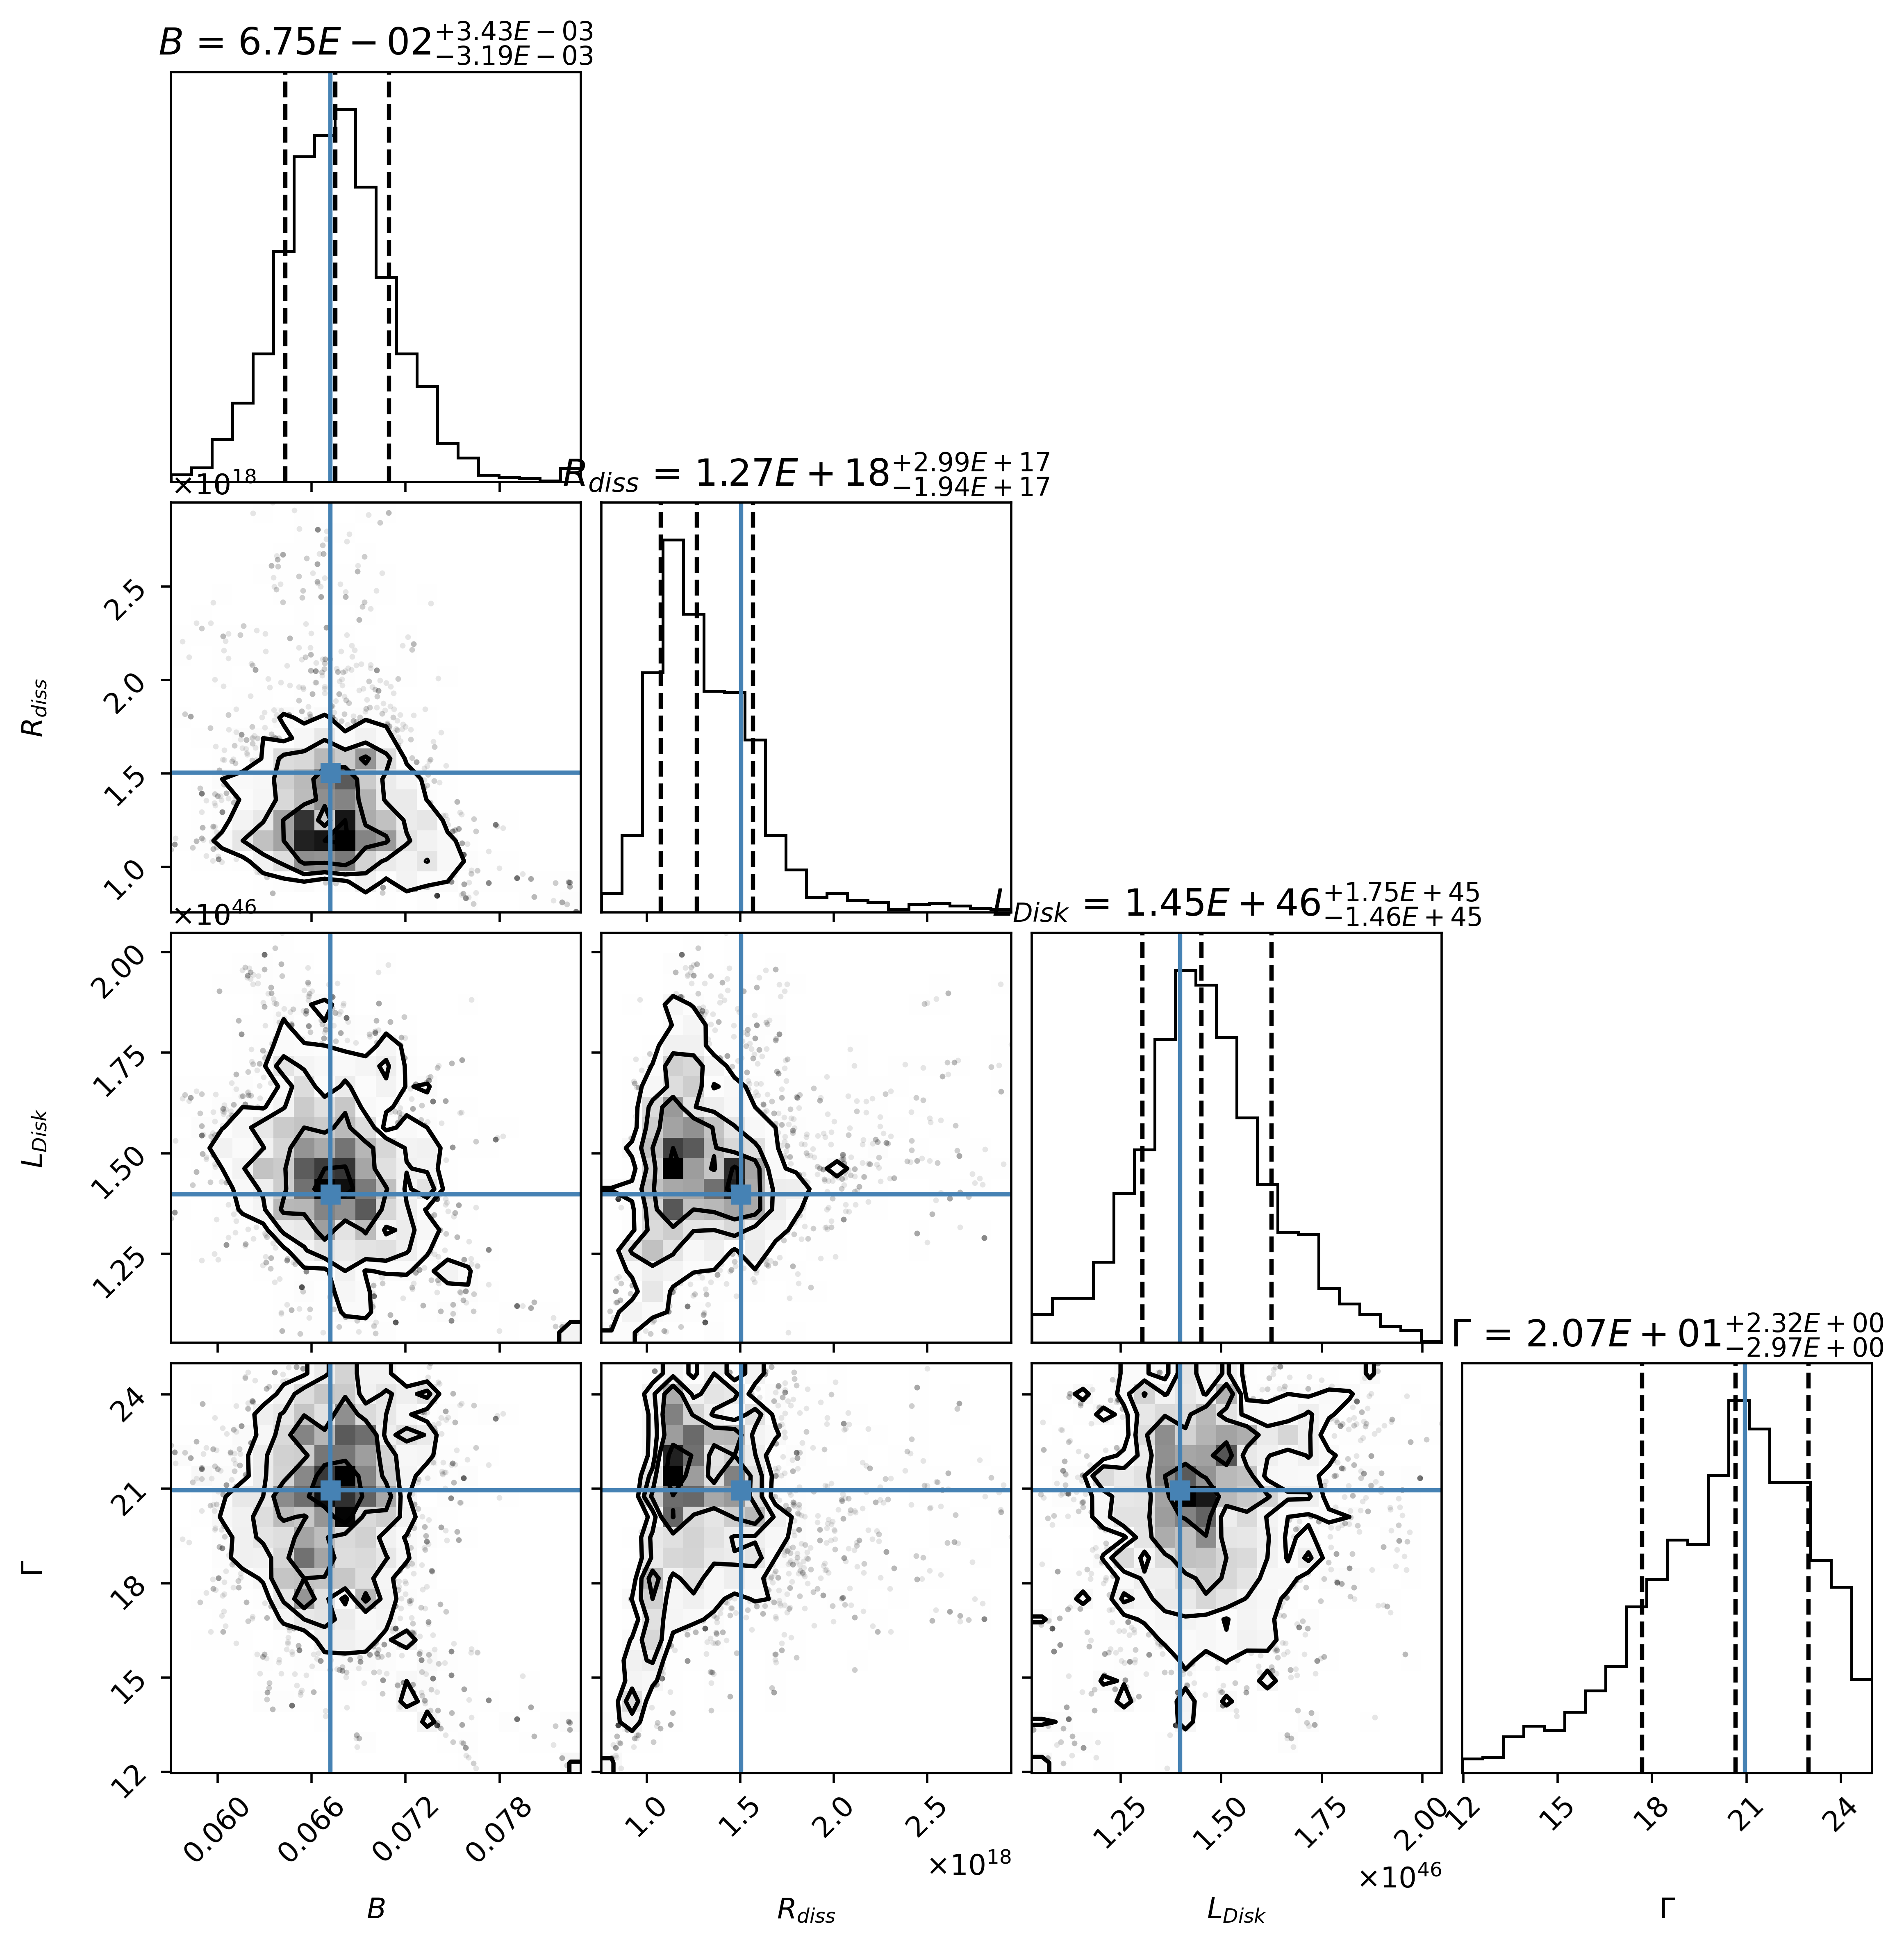

In [47]:
#This is only to have nicer labels in the plot
mcmc=McmcSampler.load('mcmc_PrePre.pkl')
labes=[r'$B$',r'$R_{diss}$',r'$L_{Disk}$',r'$\Gamma$',r'$p_{1}$']
plt.rcParams['figure.dpi'] = 500
from corner import corner

f=corner(mcmc.samples,labels=labes, quantiles=(0.16, 0.5, 0.84),
       truths=mcmc.labels_start_val, show_titles = True, 
       title_fmt=".2E",title_kwargs=dict(fontsize=13),
       use_math_text=True)
mcmc.save('mcmc_PrePre.pkl')

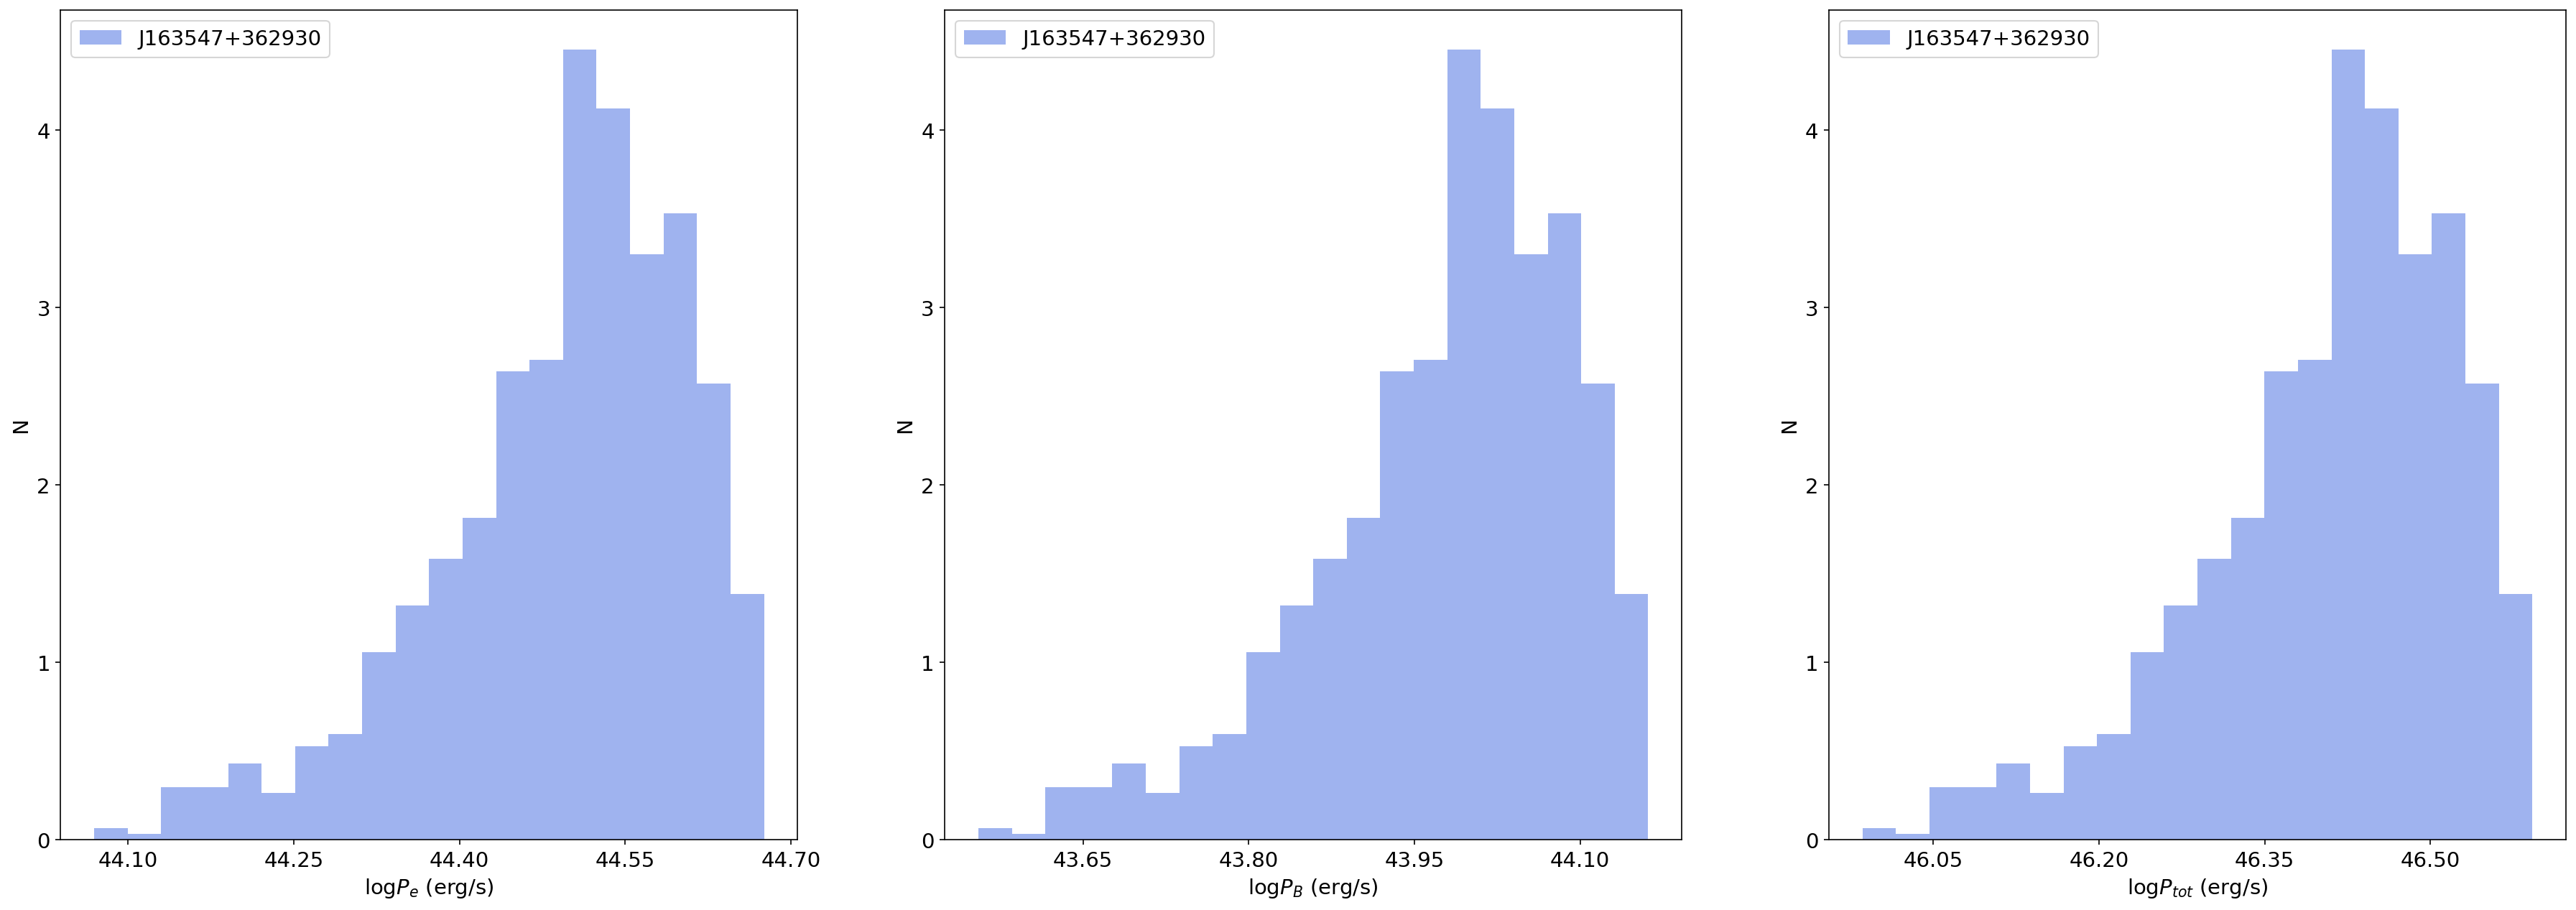

In [51]:
mcmc=McmcSampler.load('mcmc_PrePre.pkl')

n_sample=1000
size = min(len(mcmc.samples), int(n_sample))
ID_mcmc = np.random.randint(len(mcmc.samples), size=size)

energetic_dict_list=[]
for ID,ID_sample in enumerate(ID_mcmc):
    for ID_par, pi in enumerate(mcmc.par_array):
        pi.set(val=mcmc.get_par(ID_par)[0][ID_sample])
    mcmc.model.jet_leptonic.energetic_report(verbose=False)
    energetic_dict_list.append(mcmc.model.jet_leptonic.energetic_dict)
    
from matplotlib.ticker import MaxNLocator
fig, axs = plt.subplots(1, 3,figsize=(30,10),dpi=150)
p_label=['log$P_{e}$','log$P_{B}$','log$P_{tot}$']

for ID_ax,k in enumerate(['jet_L_e','jet_L_B','jet_L_tot']):
    p=np.zeros(size)
    for ID, d in enumerate(energetic_dict_list):
        p[ID]=d[k]
    
    axs.flatten()[ID_ax].xaxis.set_major_locator(MaxNLocator(5))    
    
    axs.flatten()[ID_ax].hist(np.log10(p),bins=20,density=True,label='J163547+362930',color='royalblue',alpha=0.5)
    axs.flatten()[ID_ax].set_xlabel('%s (erg/s)'%p_label[ID_ax])
    axs.flatten()[ID_ax].legend(loc='best')
    axs.flatten()[ID_ax].set_ylabel('N')
plt.rcParams.update({'font.size': 20})